# Step 0: Setting Up the Environment 

Import the needed packages


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import tree, svm
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier

## The data cleaning function

In [2]:
def transform(data: pd.DataFrame, 
              method='None',
              inplace=False, 
              drop_features = True,
              combine_rel = False,
              remove = 0
             ) -> pd.DataFrame | None:
    """
    This function cleans the data frame INPLACE.
    :param data: The data frame to clean
    :param mothod: The method of handeling the missing values where 
        "None": stands for do nothing
        "Mean": Replace missing with the Mean
        "Drop": Drop the missing values
    :param inplace: Whether to transform the dataframe in place or as a new dataframe
    :param drop_features: whether or not we want to drop useless columns.
    :param combine_rel: whether or not we want to combine Parch and SibSp as a single feature.
    :param remove: whether or not we want to drop one of the highly correlated columns Fare & Pclass.
        0 is drop none
        1 is drop Pclass
        2 is drop Fare
    :return: The transformed data frame as a new dataframe
    """
    # Make a copy of the dataframe
    df = data if inplace else data.copy()
    # First rename the complicated-name column and set the ID as Index
    df.rename(columns={"PassengerId": 'ID'}, inplace=True)
    df.set_index('ID', verify_integrity=True, inplace=True)
    # Clip the SibSp/Parch column
    df.SibSp = np.where(df.SibSp > 1, 
        2, df.SibSp)
    df.Parch = np.where(df.Parch > 1, 
        2, df.Parch)
    # Clip the Fare column
    df.Fare = np.where(df.Fare > 100, 
            100, df.Fare)
    # Handle missing Fares
    df['Fare'].fillna(value=df.Fare.mean(), inplace=True)
    # Handle the missing values according to the choosen method
    # Handle Embarked missing values
    mode = df.Embarked.mode()[0]
    df['Embarked'].replace(to_replace=np.nan, value=mode, inplace=True)
    # Handel The Age missing values
    if method == 'Drop':
        # Drop any missing values in the age column
        df.dropna(subset=['Age'], inplace=True)
    elif method == 'Mean':
        # Replace missing values in the age column with the mean age
        df['Age'].fillna(value=df.Age.mean(), inplace=True)
    # Reverse the Pclass column to be ordinal
    first = {1: 4, 3: 6}
    df['Pclass'].replace(first, inplace=True)
    second = {4: 3, 6: 1}
    df['Pclass'].replace(second, inplace=True)
    # One-Hoe Encoding for Sex Column
    df['Male'] = (df.Sex == 'male').astype(int)
    df['Female'] = (df.Sex == 'female').astype(int)
    # One-Hoe Encoding for Embarked Column
    df['EmS'] = (df.Embarked == 'S').astype(int)
    df['EmC'] = (df.Embarked == 'C').astype(int)
    df['EmQ'] = (df.Embarked == 'Q').astype(int) 
    # Drop the labeled column: Not needed
    df.drop([ 'Sex', 'Embarked'], axis=1, inplace=True)
    # Drop Useless Columns: Name, Ticket, Cabin (If choosen)
    if drop_features:
        df.drop(['Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
    # If We need to remove one of the highly correlated features
    if remove == 1:
        df.drop(['Pclass'], axis=1, inplace=True)
    elif remove == 2:
        df.drop(['Fare'], axis=1, inplace=True)
    # If we decided to combine SibSp and ParCh as a single Feature indicating number of relatives
    if combine_rel:
        df['Relatives'] = df.SibSp + df.Parch
        df.drop(['SibSp', 'Parch'], axis=1, inplace=True)
    # Return the transformed data frame as a new data frame
    return None if inplace else df

Load the data

In [3]:
df = pd.read_csv('train.csv')

Split the data into a train set and validation set

In [4]:
train, test = train_test_split(df, test_size=.2, random_state=0)

# Step1: Explore the Data (EDA)

## We will work column by column to assess and clean the data 

In [5]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
140,141,0,3,"Boulos, Mrs. Joseph (Sultana)",female,NaN,0,2,2678,15.2458,NaN,C
439,440,0,2,"Kvillner, Mr. Johan Henrik Johannesson",male,31.0,0,0,C.A. 18723,10.5000,NaN,S
817,818,0,2,"Mallet, Mr. Albert",male,31.0,1,1,S.C./PARIS 2079,37.0042,NaN,C
378,379,0,3,"Betros, Mr. Tannous",male,20.0,0,0,2648,4.0125,NaN,C
491,492,0,3,"Windelov, Mr. Einar",male,21.0,0,0,SOTON/OQ 3101317,7.2500,NaN,S


From the first look we need to set the Passenger ID as the index

```python
# First rename the complicated-name column and set the ID as Index 
    data.rename(columns={"PassengerId": 'ID', 'SibSp': 'Relatives'}, inplace=True)
    data.set_index('ID', verify_integrity=True, inplace=True)
```

Now let's investigate column by column

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 140 to 684
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Name         712 non-null    object 
 4   Sex          712 non-null    object 
 5   Age          571 non-null    float64
 6   SibSp        712 non-null    int64  
 7   Parch        712 non-null    int64  
 8   Ticket       712 non-null    object 
 9   Fare         712 non-null    float64
 10  Cabin        163 non-null    object 
 11  Embarked     710 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 72.3+ KB


All data types looks good

In [7]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,712.000000,712.000000,712.000000,571.000000,712.000000,712.000000,712.00000
mean,443.283708,0.383427,2.317416,29.745184,0.529494,0.391854,31.86295
std,260.003783,0.486563,0.833767,14.619046,1.140842,0.821368,50.13531
min,1.000000,0.000000,1.000000,0.670000,0.000000,0.000000,0.00000
25%,211.750000,0.000000,2.000000,20.750000,0.000000,0.000000,7.91770
50%,441.000000,0.000000,3.000000,29.000000,0.000000,0.000000,14.45625
75%,671.250000,1.000000,3.000000,38.000000,1.000000,0.000000,31.27500
max,890.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.32920


Looks like we have ages less than a year

In [8]:
train.query('Age < 1')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
78,79,1,2,"Caldwell, Master. Alden Gates",male,0.83,0,2,248738,29.0000,NaN,S
831,832,1,2,"Richards, Master. George Sibley",male,0.83,1,1,29106,18.7500,NaN,S
469,470,1,3,"Baclini, Miss. Helene Barbara",female,0.75,2,1,2666,19.2583,NaN,C
305,306,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S
755,756,1,2,"Hamalainen, Master. Viljo",male,0.67,1,1,250649,14.5000,NaN,S


Looks like Fare column are right skewed

## UniVariate

### PClass Column

In [9]:
train.Pclass.value_counts()

3    396
1    170
2    146
Name: Pclass, dtype: int64

<Axes: xlabel='Pclass', ylabel='count'>

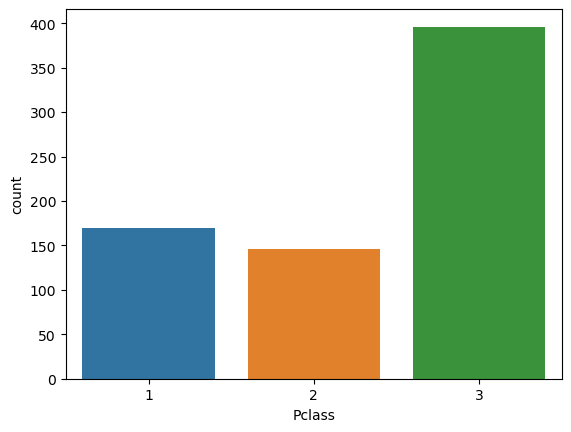

In [10]:
sns.countplot(data=train, x='Pclass')

### Name

In [11]:
train.Name.value_counts()

Boulos, Mrs. Joseph (Sultana)              1
Ford, Mrs. Edward (Margaret Ann Watson)    1
Devaney, Miss. Margaret Delia              1
Fortune, Miss. Alice Elizabeth             1
Icard, Miss. Amelie                        1
                                          ..
Artagaveytia, Mr. Ramon                    1
Goldschmidt, Mr. George B                  1
Farthing, Mr. John                         1
Nirva, Mr. Iisakki Antino Aijo             1
Brown, Mr. Thomas William Solomon          1
Name: Name, Length: 712, dtype: int64

each name appears once, useless column

### Sex

In [12]:
train.Sex.value_counts()

male      465
female    247
Name: Sex, dtype: int64

Pclass & Sex are clean but unbalanced columns

### Age

In [13]:
train.Age.value_counts()

24.00    23
30.00    22
36.00    21
22.00    21
18.00    20
         ..
12.00     1
34.50     1
70.50     1
7.00      1
0.67      1
Name: Age, Length: 86, dtype: int64

<Axes: xlabel='Age', ylabel='Count'>

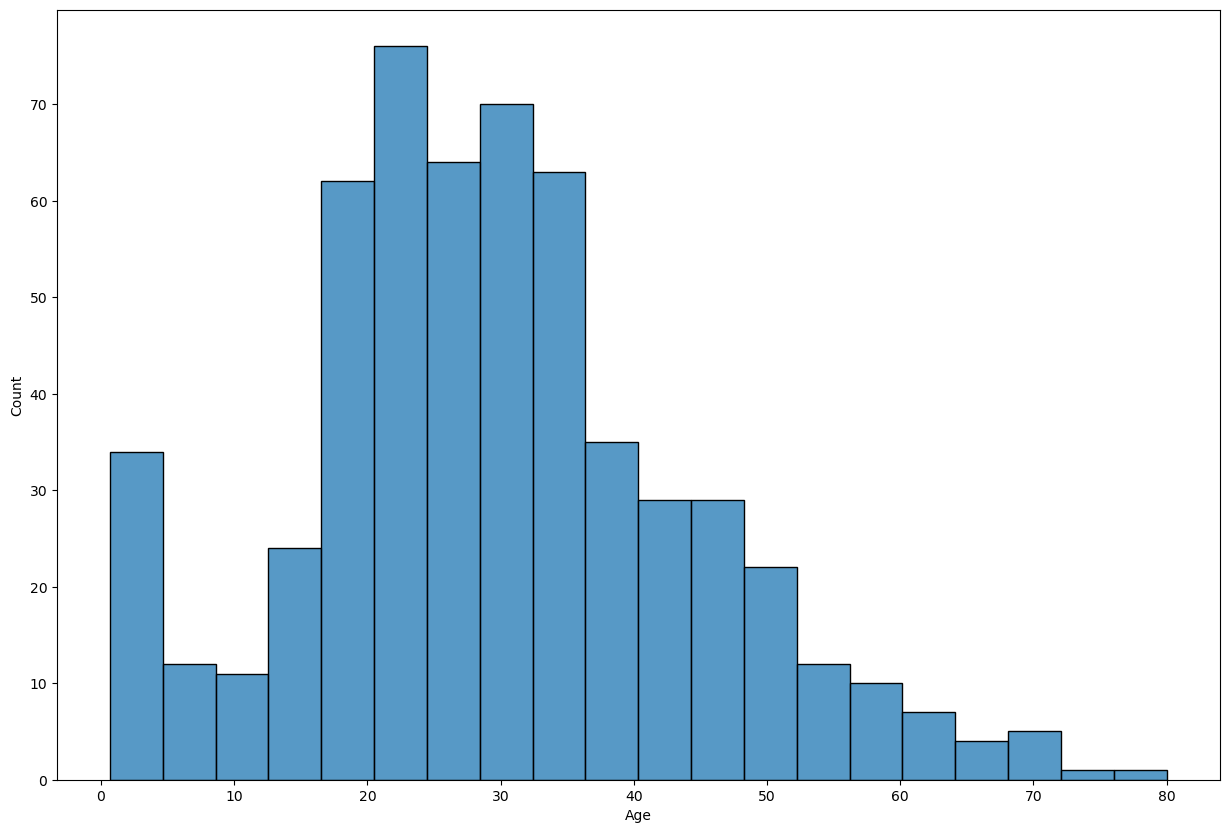

In [14]:
plt.figure(figsize=(15, 10))
sns.histplot(data=train, x='Age')

Close to normal which is good, but what about the missing values

**We have 145 (20%) missing values which is a large portion so <br>**
**Possible solution ordered are:<br>**
**1.  Chose a ML Model that knows how to deal with missing values<br>**
**2.  Replace with the Mean Age<br>**
**3.  Drop them completely<br>**

#### As I need my model to be competitive I would choose to try all

```python
# Handle the missing values according to the choosen method
    if method == 'Drop':
        # Drop any missing values in the age column
        df.dropna(subset=['Age'], inplace=True)
    elif method = 'Mean':
        # Replace missing values in the age column with the mean age
        df['Age'].fillna(value=df.Age.mean(), inplace=True)
```

### SibSp

In [15]:
train.SibSp.value_counts()

0    486
1    167
2     24
4     14
3     10
8      7
5      4
Name: SibSp, dtype: int64

8% of the rows are more that 1 so it is safe to say 0, 1, 2 where 2 holds more then one

```python
# Clip the SibSp column
df.SibSp = np.where(df.SibSp > 1, 
        2, df.SibSp)
```

### ParCh

In [16]:
train.Parch.value_counts()

0    540
1     92
2     67
3      5
5      4
4      3
6      1
Name: Parch, dtype: int64

```python
# Clip the Parch column
df.Parch = np.where(df.Parch > 1, 
        2, df.Parch)
```

### Ticket

In [17]:
train.Ticket.value_counts()

CA. 2343             7
347082               6
CA 2144              5
1601                 5
S.O.C. 14879         4
                    ..
STON/O 2. 3101280    1
A/5. 3337            1
13049                1
341826               1
345572               1
Name: Ticket, Length: 569, dtype: int64

For me I see this is a useless column as the important data is already held on the Pclass column

### Fare

In [18]:
train.Fare.value_counts()

13.0000    35
8.0500     33
7.8958     30
7.7500     28
26.0000    20
           ..
7.8750      1
76.2917     1
6.9500      1
7.8000      1
17.4000     1
Name: Fare, Length: 230, dtype: int64

<Axes: xlabel='Fare', ylabel='Density'>

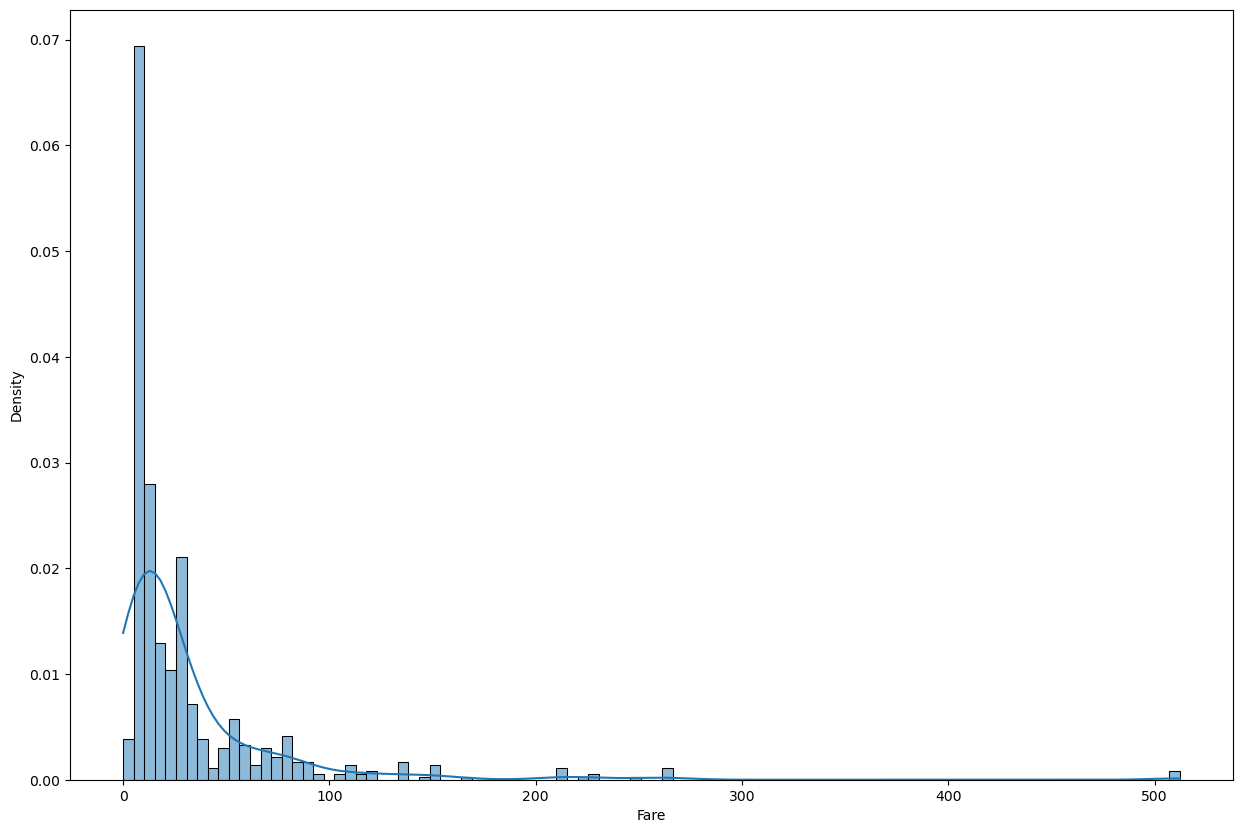

In [19]:
plt.figure(figsize=(15, 10))
sns.histplot(data=train, x='Fare', kde=True,
             bins=100, stat='density')

<Axes: xlabel='Fare', ylabel='Pclass'>

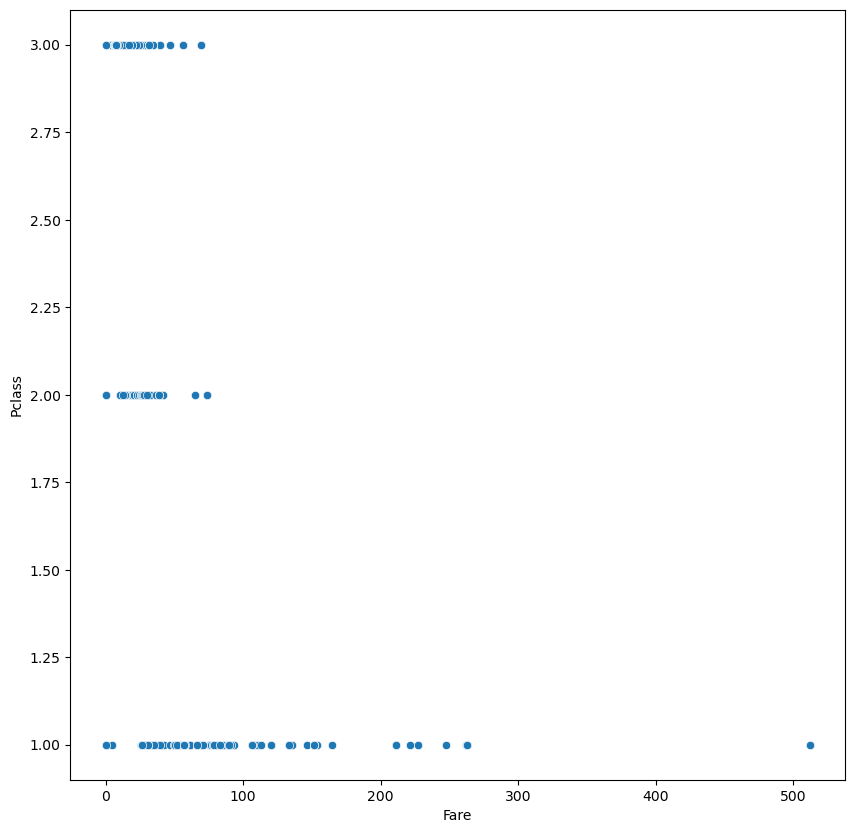

In [20]:
plt.figure(figsize=(10, 10))
sns.scatterplot(data=train, x='Fare', y='Pclass')

Weird enough, but Fare is not clearly propotional to the Class.

In [21]:
train.query("Fare > 200").shape

(15, 12)

In [22]:
print(train.query("Fare > 100").Survived.mean(), 
      train.query("Fare > 200").Survived.mean())

0.7 0.6666666666666666


easy to clip it to set any fare higher than 100 as high fare.

```python
# Clip the Fare column
df.Fare = np.where(df.Fare > 100, 
        100, df.Fare)
```

### Cabin

In [23]:
train.Cabin.value_counts()

C23 C25 C27    3
G6             3
C22 C26        3
E101           3
D              3
              ..
D17            1
D50            1
A14            1
A36            1
E49            1
Name: Cabin, Length: 127, dtype: int64

This is a useless column

### Embarked

In [24]:
train.Embarked.value_counts()

S    517
C    129
Q     64
Name: Embarked, dtype: int64

I say we replace missnig values with the mode

```python
# Handle Embarked missing values
    df['Embarked'].fillna(value=df.Embarked.mode(), inplace=True)
```

# Conclusion 

1. ### We handeled missing values
      * For Age column.
      * For Embaeked Column
2. ### (Optionally) Dropped useless columns
      * Name
      * Ticket
      * Cabin
      
```python
    # Drop Useless Columns: Name, Ticket, Cabin (If choosen)
    if drop_features:
        df.drop(['Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
```

In [25]:
trimmed = transform(train, method='Drop')
replaced = transform(train, method='Mean')
new = transform(train)

### WE have 6 dataframes:
  1. #### Trimmed: Droped the missing ages
  2. #### Replaced: Replaced missing ages with mean age
  3. #### New: Did nothing to the missing ages.
  4. #### Train: The dirty train data
  5. #### Test: The validation data
  6. #### Df: The data itself untouched

# Feature Selection

## BiVariate/MultiVariate

In [26]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
140,141,0,3,"Boulos, Mrs. Joseph (Sultana)",female,NaN,0,2,2678,15.2458,NaN,C
439,440,0,2,"Kvillner, Mr. Johan Henrik Johannesson",male,31.0,0,0,C.A. 18723,10.5000,NaN,S
817,818,0,2,"Mallet, Mr. Albert",male,31.0,1,1,S.C./PARIS 2079,37.0042,NaN,C
378,379,0,3,"Betros, Mr. Tannous",male,20.0,0,0,2648,4.0125,NaN,C
491,492,0,3,"Windelov, Mr. Einar",male,21.0,0,0,SOTON/OQ 3101317,7.2500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
835,836,1,1,"Compton, Miss. Sara Rebecca",female,39.0,1,1,PC 17756,83.1583,E49,C
192,193,1,3,"Andersen-Jensen, Miss. Carla Christine Nielsine",female,19.0,1,0,350046,7.8542,NaN,S
629,630,0,3,"O'Connell, Mr. Patrick D",male,NaN,0,0,334912,7.7333,NaN,Q
559,560,1,3,"de Messemaeker, Mrs. Guillaume Joseph (Emma)",female,36.0,1,0,345572,17.4000,NaN,S


In [27]:
new.count()

Survived    712
Pclass      712
Age         571
SibSp       712
Parch       712
Fare        712
Male        712
Female      712
EmS         712
EmC         712
EmQ         712
dtype: int64

#### Pclass

<Axes: xlabel='Pclass', ylabel='Survived'>

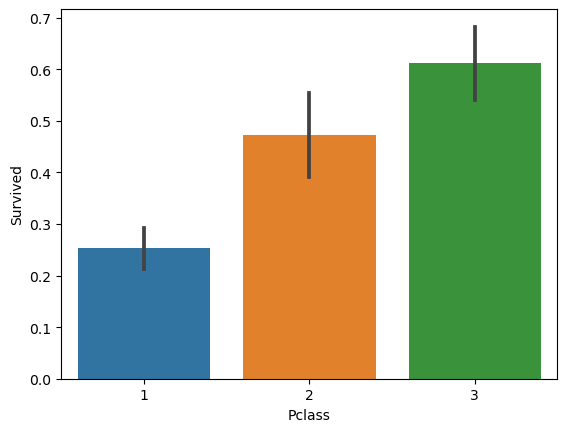

In [28]:
sns.barplot(data=new, x='Pclass', y='Survived')

### Sex

<Axes: xlabel='Sex', ylabel='Survived'>

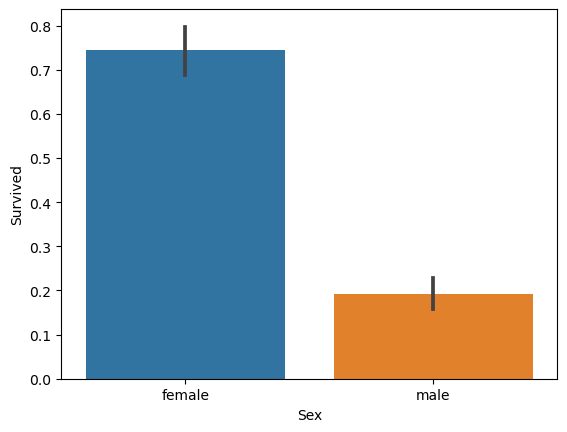

In [29]:
sns.barplot(data=train, x='Sex', y='Survived')

### Age

<Axes: xlabel='Survived', ylabel='Age'>

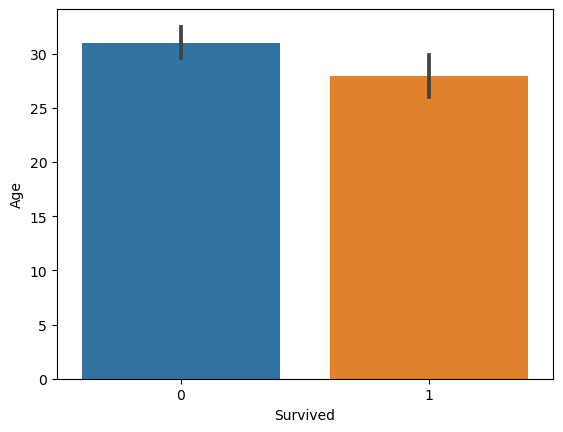

In [30]:
sns.barplot(data=new, x='Survived', y='Age')

### SibSp & PArch

<Axes: xlabel='SibSp', ylabel='Survived'>

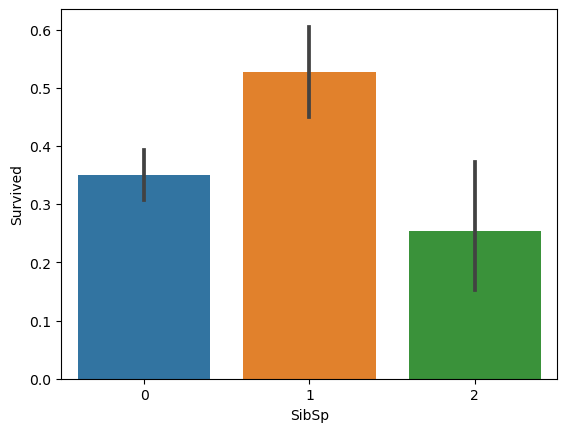

In [31]:
sns.barplot(data=new, x='SibSp', y='Survived')

<Axes: xlabel='Parch', ylabel='Survived'>

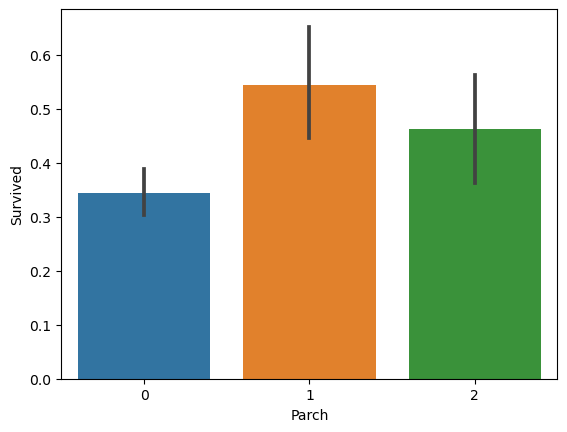

In [32]:
sns.barplot(data=new, x='Parch', y='Survived')

### Embarked

<Axes: xlabel='Embarked', ylabel='Survived'>

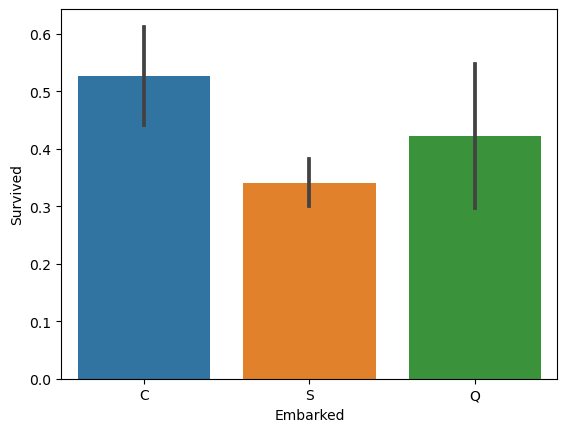

In [33]:
sns.barplot(data=train, x='Embarked', y='Survived')

### Fare

<Axes: xlabel='Survived', ylabel='Fare'>

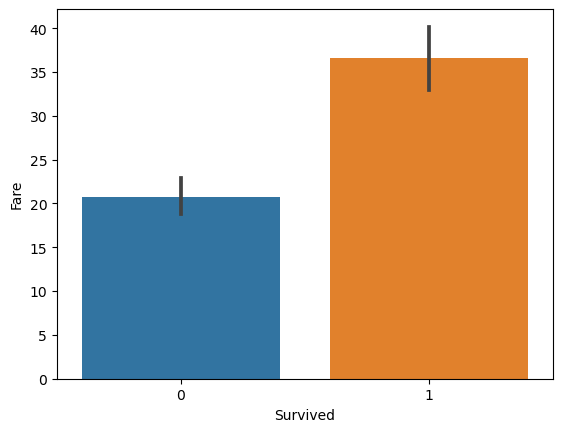

In [34]:
sns.barplot(data=new, x='Survived', y='Fare')

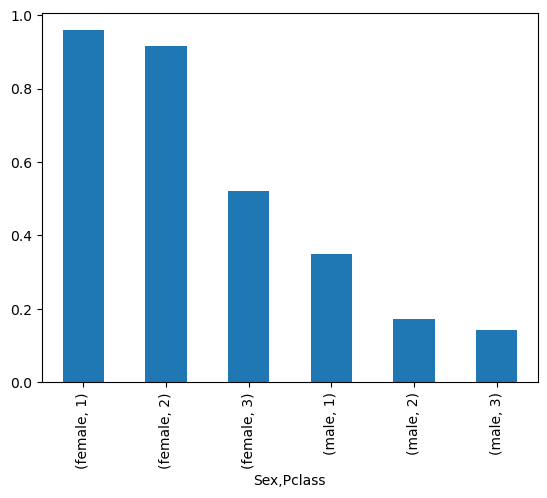

In [35]:
train.groupby(['Sex', 'Pclass']).Survived.mean().plot(kind='bar');

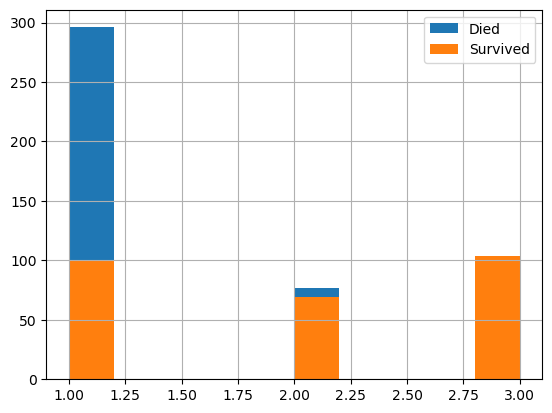

In [36]:
new.query('Survived == 0').Pclass.hist(label="Died")
new.query('Survived == 1').Pclass.hist(label="Survived")
plt.legend();

## Let's see the correlation to check for multicollinearity

<Axes: >

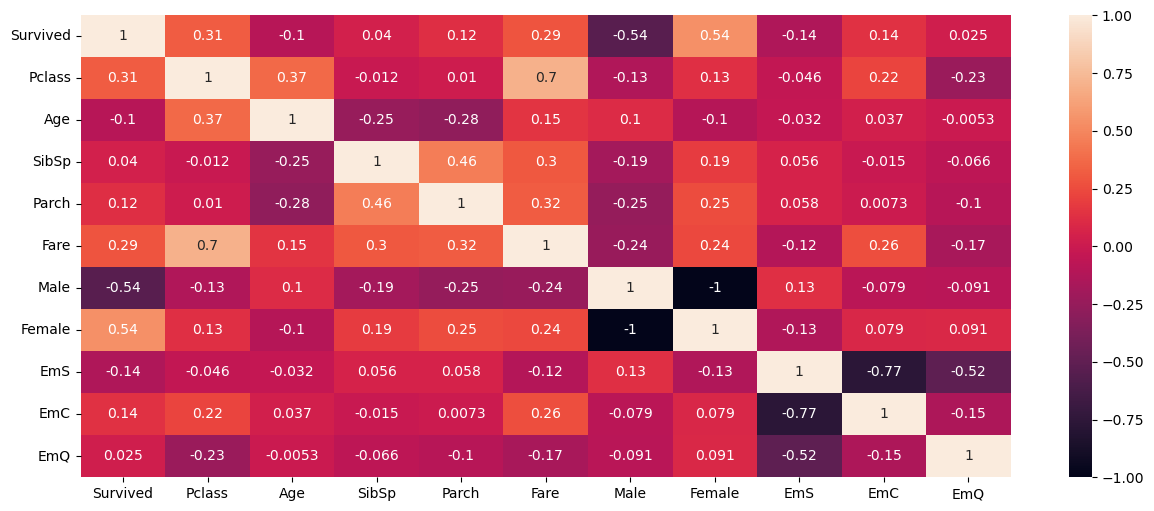

In [37]:
corr = new.corr()
plt.figure(figsize=(15, 6))
sns.heatmap(corr, annot=True)

### AS EXPECTED<br>
#### Pclass and Fare are correlated and so is ParCh and SibSp

### ParCh & SibSp

In [38]:
new.groupby(['SibSp', 'Parch']).Survived.agg(['count'])

count
SibSp Parch       
0     0        430
      1         30
      2         26
1     0         96
      1         43
      2         28
2     0         14
      1         19
      2         26

We have to options:
Ignore the .46 correlation or add them as a relatives column holding all relatives<br>
but I would prefer ignoring them

### Fare & Pclass

Highly correlated (.7)

First things first, we need to handle the - sign, so to avoid confusing the model we will reverse the Pclass column<br>
1 is lower class and 3 is higher

In [39]:
new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 141 to 685
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  712 non-null    int64  
 1   Pclass    712 non-null    int64  
 2   Age       571 non-null    float64
 3   SibSp     712 non-null    int64  
 4   Parch     712 non-null    int64  
 5   Fare      712 non-null    float64
 6   Male      712 non-null    int32  
 7   Female    712 non-null    int32  
 8   EmS       712 non-null    int32  
 9   EmC       712 non-null    int32  
 10  EmQ       712 non-null    int32  
dtypes: float64(2), int32(5), int64(4)
memory usage: 52.8 KB


```python
first = {1: 4, 3: 6}
df['Pclass'].replace(first, inplace=True)
second = {4: 3, 6: 1}
df['Pclass'].replace(second, inplace=True)
```

Now we have to scenarios even to drop Fare or Pclass or to leave them

# Getting data ready for the model

In [40]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 140 to 684
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Name         712 non-null    object 
 4   Sex          712 non-null    object 
 5   Age          571 non-null    float64
 6   SibSp        712 non-null    int64  
 7   Parch        712 non-null    int64  
 8   Ticket       712 non-null    object 
 9   Fare         712 non-null    float64
 10  Cabin        163 non-null    object 
 11  Embarked     710 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 72.3+ KB


### Most of the columns are numeric which is perfect, but Sex and Embarked are not

#### I would go for one-hot encoding for both

### Sex

```python
df['Male'] = (df.Sex == 'male').astype(int)
df['Female'] = (df.Sex == 'female').astype(int)
```

### Embarked

```python
df['EmS'] = (df.Embarked == 'S').astype(int)
df['EmC'] = (df.Embarked == 'C').astype(int)
df['EmQ'] = (df.Embarked == 'Q').astype(int)
```

# conclusion 

1. ### We have reversed the Pclass Column
2. ### Applied one-hot encoding to the non numeric features.
3. ### (Optionally) handeled highly correlated features

```python
    if remove == 1:
        df.drop(['Pclass'], axis=1, inplace=True)
    elif remove == 2:
        df.drop(['Fare'], axis=1, inplace=True)
    # If we decided to combine SibSp and ParCh as a single Feature indicating number of relatives
    if combine_rel:
        df['Relatives'] = df.SibSp + df.Parch
        df.drop(['SibSp', 'Parch'], axis=1, inplace=True)
```

### All looks good and ready for modeling, but first let me show all the scenarios we have till the moment

As we have hyper parameters for each ML Model, the way I implemented the transformer function allowed us to have hyper parameters for the cleaning process.

Follow this Flow Chart to get all the possible senarios.

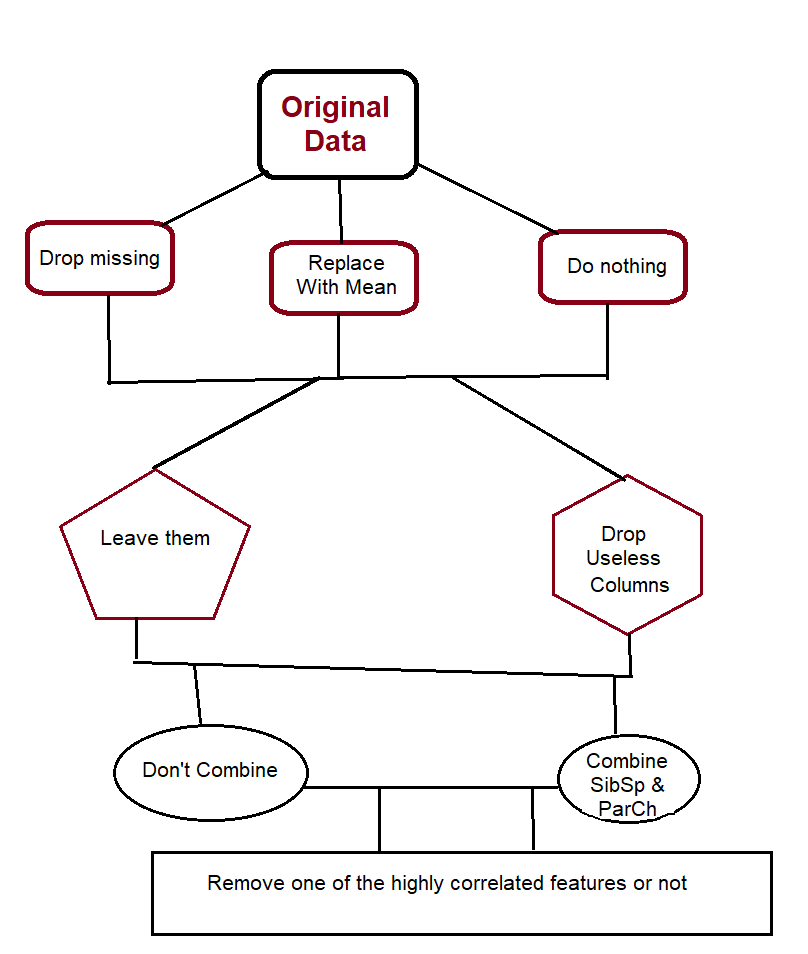

As it is clear in the picture we have some choices to make deciding how to clean the data

## Examine Features Importance

In [41]:
new = transform(train, method='Mean')
x = new.drop(["Survived"], axis=1)
y = new[['Survived']]
feature_names = [f"{i}" for i in x.columns]
forest = RandomForestClassifier(random_state=0)
forest.fit(x, y)
importances = forest.feature_importances_

C:\Users\al-ghaly\AppData\Local\Temp\ipykernel_32868\3390003696.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest.fit(x, y)


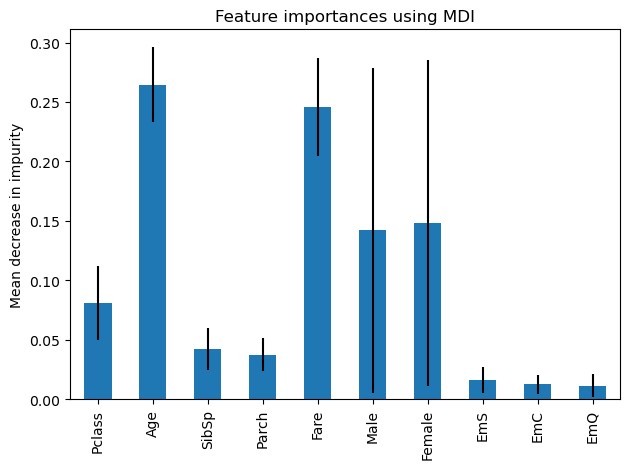

In [42]:
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_names)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

# Modeling

## Models will be handeled using Functional Programming to make it easier to attempt many times.

In [43]:
def model(train_data: pd.DataFrame, test_data: pd.DataFrame):
    # Get the training features
    train_x = train_data.drop(["Survived"], axis=1)
    # Get the training labels
    train_y = train_data[['Survived']]
    # Get the Test features and labels
    test_x = test_data.drop(["Survived"], axis=1)
    test_y = test_data[['Survived']]
    
    # Train a Logistic Regression Model
    clf = LogisticRegression(random_state=0).fit(train_x, train_y)
    y_pred_train = clf.predict(train_x)
    y_pred_test = clf.predict(test_x)
    train_score = round(accuracy_score(train_y, y_pred_train), 4)
    test_score = round(accuracy_score(test_y, y_pred_test), 4)
    print(f"For the Logistic Regression Model the accuracy is: \n {train_score} for Training data and {test_score} for validation data")
    
    # Train a Decision Tree Model
    model = tree.DecisionTreeClassifier(random_state=0)
    model = model.fit(train_x, train_y)
    y_pred_test = model.predict(test_x)
    y_pred_train = model.predict(train_x)
    train_score = round(accuracy_score(train_y, y_pred_train), 4)
    test_score = round(accuracy_score(test_y, y_pred_test), 4)
    print(f"For the Decision Tree Model the accuracy is: \n {train_score} for Training data and {test_score} for validation data")
    
    # Train a Random Forrest model
    model = RandomForestClassifier(random_state=0)
    model = model.fit(train_x, train_y)
    y_pred_test = model.predict(test_x)
    y_pred_train = model.predict(train_x)
    train_score = round(accuracy_score(train_y, y_pred_train), 4)
    test_score = round(accuracy_score(test_y, y_pred_test), 4)
    print(f"For the Random Forrest Model the accuracy is: \n {train_score} for Training data and {test_score} for validation data")
    
    # Train SVM Model
    model = svm.SVC(random_state=0)
    model = model.fit(train_x, train_y)
    y_pred_test = model.predict(test_x)
    y_pred_train = model.predict(train_x)
    train_score = round(accuracy_score(train_y, y_pred_train), 4)
    test_score = round(accuracy_score(test_y, y_pred_test), 4)
    print(f"For the SVM Model the accuracy is: \n {train_score} for Training data and {test_score} for validation data")
    
    # Ada Boost Model
    model = AdaBoostClassifier(n_estimators=100, random_state=0)
    model = model.fit(train_x, train_y)
    y_pred_test = model.predict(test_x)
    y_pred_train = model.predict(train_x)
    train_score = round(accuracy_score(train_y, y_pred_train), 4)
    test_score = round(accuracy_score(test_y, y_pred_test), 4)
    print(f"For the Ada Boost Model the accuracy is: \n {train_score} for Training data and {test_score} for validation data")
    
    # Boosting
    model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
    max_depth=1, random_state=0)
    model = model.fit(train_x, train_y)
    y_pred_test = model.predict(test_x)
    y_pred_train = model.predict(train_x)
    train_score = round(accuracy_score(train_y, y_pred_train), 4)
    test_score = round(accuracy_score(test_y, y_pred_test), 4)
    print(f"For the Gradient Boosting Model the accuracy is: \n {train_score} for Training data and {test_score} for validation data")
    

### Replace missing ages with mean, Drop useless columns, don't handle multicollinearity

Average Accuracy is: 79.8 %  
Best Accuracy is   : 84   % 

In [44]:
test_data = transform(test, method='Mean')
train_data = transform(train, method='Mean')
model(train_data, test_data)

C:\Users\al-ghaly\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\al-ghaly\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\al-ghaly\AppData\Local\Temp\ipykernel_32868\2852736931.py:29: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example usi

For the Logistic Regression Model the accuracy is: 
 0.8006 for Training data and 0.8045 for validation data
For the Decision Tree Model the accuracy is: 
 0.9817 for Training data and 0.7709 for validation data
For the Random Forrest Model the accuracy is: 
 0.9817 for Training data and 0.838 for validation data
For the SVM Model the accuracy is: 
 0.6671 for Training data and 0.7207 for validation data


C:\Users\al-ghaly\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\al-ghaly\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For the Ada Boost Model the accuracy is: 
 0.8413 for Training data and 0.8212 for validation data
For the Gradient Boosting Model the accuracy is: 
 0.8511 for Training data and 0.8268 for validation data


C:\Users\al-ghaly\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# 1. Logistic Regression

Being a Binary Classification I would start with the Logistic Regression

### Train Accuracy: 80%<br>Validation Accuracy: 80.5%. 

# 2. Decision Tree

### Train Accuracy: 98%<br>Validation Accuracy: 77%. 

# 3. Random Forrest

### Train Accuracy: 98%<br>Validation Accuracy: 84%. 

#  4. SVM

### Train Accuracy: 67%<br>Validation Accuracy: 72%. 

# 5. Ada Boost

### Train Accuracy: 84%<br>Validation Accuracy: 82%. 

# 6. Boosting

### Train Accuracy: 85%<br>Validation Accuracy: 83%. 

<hr style="border-top: 15px solid #bbb;">

# Let's change how we clean the data

### Don't Replace missing ages (Drop It), Drop useless columns, don't handle multicollinearity

Average Accuracy is: 79.14 %  
Best Accuracy is   : 82.1 % 

In [45]:
test_data = transform(test, method='Mean')
train_data = transform(train, method='Drop')
model(train_data, test_data)

C:\Users\al-ghaly\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\al-ghaly\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\al-ghaly\AppData\Local\Temp\ipykernel_32868\2852736931.py:29: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example usi

For the Logistic Regression Model the accuracy is: 
 0.8004 for Training data and 0.8045 for validation data
For the Decision Tree Model the accuracy is: 
 0.986 for Training data and 0.7765 for validation data
For the Random Forrest Model the accuracy is: 
 0.986 for Training data and 0.8212 for validation data
For the SVM Model the accuracy is: 
 0.6743 for Training data and 0.7151 for validation data


C:\Users\al-ghaly\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\al-ghaly\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For the Ada Boost Model the accuracy is: 
 0.8476 for Training data and 0.8101 for validation data
For the Gradient Boosting Model the accuracy is: 
 0.8581 for Training data and 0.8212 for validation data


C:\Users\al-ghaly\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<hr style="border-top: 15px solid #bbb;">

### Don't Replace missing ages (Drop It), Drop useless columns, and handle relatives multicollinearity

Average Accuracy is: 80.4 %  
Best Accuracy is   : 86.6 % 

In [46]:
test_data = transform(test, method='Mean', combine_rel=True)
train_data = transform(train, method='Drop', combine_rel=True)
model(train_data, test_data)

For the Logistic Regression Model the accuracy is: 
 0.7968 for Training data and 0.8156 for validation data
For the Decision Tree Model the accuracy is: 
 0.986 for Training data and 0.7709 for validation data


C:\Users\al-ghaly\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\al-ghaly\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\al-ghaly\AppData\Local\Temp\ipykernel_32868\2852736931.py:29: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example usi

For the Random Forrest Model the accuracy is: 
 0.986 for Training data and 0.8659 for validation data
For the SVM Model the accuracy is: 
 0.6743 for Training data and 0.7207 for validation data


C:\Users\al-ghaly\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\al-ghaly\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For the Ada Boost Model the accuracy is: 
 0.8424 for Training data and 0.8212 for validation data
For the Gradient Boosting Model the accuracy is: 
 0.8564 for Training data and 0.8268 for validation data


C:\Users\al-ghaly\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<hr style="border-top: 15px solid #bbb;">

### Don't Replace missing ages (Drop It), Drop useless columns, and Fare|Pclass multicollinearity

Average Accuracy is: 78   %  
Best Accuracy is   : 80.5 % 

In [47]:
test_data = transform(test, method='Mean', remove=1)
train_data = transform(train, method='Drop', remove=1)
model(train_data, test_data)

C:\Users\al-ghaly\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\al-ghaly\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\al-ghaly\AppData\Local\Temp\ipykernel_32868\2852736931.py:29: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example usi

For the Logistic Regression Model the accuracy is: 
 0.7653 for Training data and 0.7821 for validation data
For the Decision Tree Model the accuracy is: 
 0.986 for Training data and 0.7709 for validation data
For the Random Forrest Model the accuracy is: 
 0.986 for Training data and 0.8045 for validation data
For the SVM Model the accuracy is: 
 0.6743 for Training data and 0.7151 for validation data


C:\Users\al-ghaly\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\al-ghaly\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For the Ada Boost Model the accuracy is: 
 0.8301 for Training data and 0.8045 for validation data
For the Gradient Boosting Model the accuracy is: 
 0.8389 for Training data and 0.7933 for validation data


C:\Users\al-ghaly\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<hr style="border-top: 15px solid #bbb;">

Average Accuracy is: 77.6 %  
Best Accuracy is   : 82.7 % 

In [48]:
test_data = transform(test, method='Mean', remove=2)
train_data = transform(train, method='Drop', remove=2)
model(train_data, test_data)

C:\Users\al-ghaly\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\al-ghaly\AppData\Local\Temp\ipykernel_32868\2852736931.py:29: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model = model.fit(train_x, train_y)


For the Logistic Regression Model the accuracy is: 
 0.8021 for Training data and 0.8045 for validation data
For the Decision Tree Model the accuracy is: 
 0.944 for Training data and 0.7933 for validation data
For the Random Forrest Model the accuracy is: 
 0.944 for Training data and 0.7989 for validation data
For the SVM Model the accuracy is: 
 0.6165 for Training data and 0.6313 for validation data


C:\Users\al-ghaly\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\al-ghaly\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For the Ada Boost Model the accuracy is: 
 0.8214 for Training data and 0.8268 for validation data
For the Gradient Boosting Model the accuracy is: 
 0.8354 for Training data and 0.8045 for validation data


C:\Users\al-ghaly\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<hr style="border-top: 15px solid #bbb;">

### Don't Replace missing ages (Drop It), Drop useless columns, and Both multicollinearity

Average Accuracy is: 79.7 %  
Best Accuracy is   : 82.7 % 

In [49]:
test_data = transform(test, method='Mean', combine_rel=True, remove=1)
train_data = transform(train, method='Drop', combine_rel=True, remove=1)
model(train_data, test_data)

C:\Users\al-ghaly\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\al-ghaly\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\al-ghaly\AppData\Local\Temp\ipykernel_32868\2852736931.py:29: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example usi

For the Logistic Regression Model the accuracy is: 
 0.7723 for Training data and 0.7877 for validation data
For the Decision Tree Model the accuracy is: 
 0.986 for Training data and 0.7765 for validation data
For the Random Forrest Model the accuracy is: 
 0.986 for Training data and 0.8101 for validation data
For the SVM Model the accuracy is: 
 0.6743 for Training data and 0.7207 for validation data


C:\Users\al-ghaly\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\al-ghaly\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For the Ada Boost Model the accuracy is: 
 0.8301 for Training data and 0.8268 for validation data
For the Gradient Boosting Model the accuracy is: 
 0.8336 for Training data and 0.8101 for validation data


C:\Users\al-ghaly\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Don't Replace missing ages (Drop It), Drop useless columns, and Both multicollinearity

Average Accuracy is: 79.3 %  
Best Accuracy is   : 84.  % 

In [50]:
test_data = transform(test, method='Mean', combine_rel=True, remove=2)
train_data = transform(train, method='Drop', combine_rel=True, remove=2)
model(train_data, test_data)

For the Logistic Regression Model the accuracy is: 
 0.7968 for Training data and 0.8156 for validation data
For the Decision Tree Model the accuracy is: 
 0.9387 for Training data and 0.8212 for validation data


C:\Users\al-ghaly\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\al-ghaly\AppData\Local\Temp\ipykernel_32868\2852736931.py:29: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model = model.fit(train_x, train_y)


For the Random Forrest Model the accuracy is: 
 0.9387 for Training data and 0.7933 for validation data
For the SVM Model the accuracy is: 
 0.6147 for Training data and 0.6313 for validation data


C:\Users\al-ghaly\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\al-ghaly\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For the Ada Boost Model the accuracy is: 
 0.8179 for Training data and 0.838 for validation data
For the Gradient Boosting Model the accuracy is: 
 0.8301 for Training data and 0.8212 for validation data


C:\Users\al-ghaly\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<hr style="border-top: 15px solid #bbb;">

# Try out more Models

In [51]:
train, test = train_test_split(df, test_size=.3, random_state=0)
transform(test, method='Mean', combine_rel=True, inplace=True)
transform(train, method='Drop', combine_rel=True, inplace=True)

In [52]:
# Get the training features
train_x = train.drop(["Survived"], axis=1)
# Get the training labels
train_y = train[['Survived']]
# Get the Test features and labels
test_x = test.drop(["Survived"], axis=1)
test_y = test[['Survived']]

# Naive Bayes

Average Accuracy is: 75.2 %  
Best Accuracy is   : 78.7 % 

### Gaussian Naive Bayes

In [53]:
gnb = GaussianNB()
gnb.fit(train_x, train_y)
y_pred_train = gnb.predict(train_x)
y_pred_test = gnb.predict(test_x)
train_score = round(accuracy_score(train_y, y_pred_train), 4)
test_score = round(accuracy_score(test_y, y_pred_test), 4)
print(f"For the Gaussian Naive Bayes Model the accuracy is: \n {train_score} for Training data and {test_score} for validation data")

For the Gaussian Naive Bayes Model the accuracy is: 
 0.759 for Training data and 0.7575 for validation data


C:\Users\al-ghaly\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Multinomial Naive Bayes

In [54]:
clf = MultinomialNB(force_alpha=True)
clf.fit(train_x, train_y)
y_pred_train = clf.predict(train_x)
y_pred_test = clf.predict(test_x)
train_score = round(accuracy_score(train_y, y_pred_train), 4)
test_score = round(accuracy_score(test_y, y_pred_test), 4)
print(f"For the Multinomial Naive Bayes Model the accuracy is: \n {train_score} for Training data and {test_score} for validation data")

For the Multinomial Naive Bayes Model the accuracy is: 
 0.6992 for Training data and 0.7276 for validation data


C:\Users\al-ghaly\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Bernoulli Naive Bayes

In [55]:
clf = BernoulliNB(force_alpha=True)
clf.fit(train_x, train_y)
y_pred_train = clf.predict(train_x)
y_pred_test = clf.predict(test_x)
train_score = round(accuracy_score(train_y, y_pred_train), 4)
test_score = round(accuracy_score(test_y, y_pred_test), 4)
print(f"For the Bernoulli Naive Bayes Model the accuracy is: \n {train_score} for Training data and {test_score} for validation data")

For the Bernoulli Naive Bayes Model the accuracy is: 
 0.7769 for Training data and 0.7873 for validation data


C:\Users\al-ghaly\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Complement Naive Bayes

In [56]:
clf = ComplementNB(force_alpha=True)
clf.fit(train_x, train_y)
y_pred_train = clf.predict(train_x)
y_pred_test = clf.predict(test_x)
train_score = round(accuracy_score(train_y, y_pred_train), 4)
test_score = round(accuracy_score(test_y, y_pred_test), 4)
print(f"For the Complement Naive Bayes Model the accuracy is: \n {train_score} for Training data and {test_score} for validation data")

For the Complement Naive Bayes Model the accuracy is: 
 0.6972 for Training data and 0.7351 for validation data


C:\Users\al-ghaly\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<hr style="border-top: 15px solid #bbb;">

# KNN

Accuracy is   : 70   % 

In [57]:
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(train_x, train_y)
y_pred_train = neigh.predict(train_x)
y_pred_test = neigh.predict(test_x)
train_score = round(accuracy_score(train_y, y_pred_train), 4)
test_score = round(accuracy_score(test_y, y_pred_test), 4)
print(f"For the KNN Model the accuracy is: \n {train_score} for Training data and {test_score} for validation data")

C:\Users\al-ghaly\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


For the KNN Model the accuracy is: 
 0.8167 for Training data and 0.7015 for validation data


# Time to test the model

### Don't Replace missing ages (Drop It), Drop useless columns, and handle relatives multicollinearity¶

In [58]:
test_x = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')
transform(test_x, method='Mean', combine_rel=True, inplace=True)
transform(train, method='Drop', combine_rel=True, inplace=True)
train_x = train.drop(["Survived"], axis=1)
# Get the training labels
train_y = train[['Survived']]


#### Random Forrest Model

In [59]:
# Train a Random Forrest model
model = RandomForestClassifier(random_state=0)
model = model.fit(train_x, train_y)
y_pred = model.predict(test_x)


C:\Users\al-ghaly\AppData\Local\Temp\ipykernel_32868\3782337803.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model = model.fit(train_x, train_y)


In [60]:
results_df = pd.DataFrame({'Survived': y_pred}, index=test_x.index)

In [61]:
results_df.to_csv('Predictions.csv')

# GOT SCORE OF: 75.2 %

<hr style="border-top: 15px solid #bbb;">